<a href="https://colab.research.google.com/github/ambideXtrous9/Text-Summarization-using-T5/blob/main/Text_Summarization_usinng_T5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Fri Sep 16 19:49:17 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# **Install Required Libraries**

In [4]:
!pip install --quiet pytorch_lightning
!pip install --quiet  transformers
!pip install --quiet  seaborn
!pip install --quiet  wget

# **Import Required Libraries**

In [5]:
import pytorch_lightning as pl
import json
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.model_selection import train_test_split
from termcolor import colored
import textwrap

from transformers import AdamW, T5ForConditionalGeneration, T5TokenizerFast as T5Tokenizer
from tqdm.auto import tqdm

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

sns.set(style='whitegrid',palette='muted',font_scale=1.2)
rcParams['figure.figsize'] = 16, 6

In [15]:
pl.seed_everything(42)

INFO:pytorch_lightning.utilities.seed:Global seed set to 42


42

#**Loading the Dataset**

In [16]:
url = 'https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary.csv'

In [17]:
df = pd.read_csv(url,encoding='latin')

In [18]:
df.columns

Index(['author', 'date', 'headlines', 'read_more', 'text', 'ctext'], dtype='object')

In [19]:
df = df[["text","ctext"]]
df.head()

,text,ctext
0,The Administration of Union Territory Daman an...,The Daman and Diu administration on Wednesday ...
1,Malaika Arora slammed an Instagram user who tr...,"From her special numbers to TV?appearances, Bo..."
2,The Indira Gandhi Institute of Medical Science...,The Indira Gandhi Institute of Medical Science...
3,Lashkar-e-Taiba's Kashmir commander Abu Dujana...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...
4,Hotels in Maharashtra will train their staff t...,Hotels in Mumbai and other Indian cities are t...


In [20]:
df.columns

Index(['text', 'ctext'], dtype='object')

# **Overview of the Dataset**

In [21]:
df.columns = ["summary", "text"]
df = df.dropna()
df.head()

,summary,text
0,The Administration of Union Territory Daman an...,The Daman and Diu administration on Wednesday ...
1,Malaika Arora slammed an Instagram user who tr...,"From her special numbers to TV?appearances, Bo..."
2,The Indira Gandhi Institute of Medical Science...,The Indira Gandhi Institute of Medical Science...
3,Lashkar-e-Taiba's Kashmir commander Abu Dujana...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...
4,Hotels in Maharashtra will train their staff t...,Hotels in Mumbai and other Indian cities are t...


In [22]:
df.shape

(4396, 2)

# **Train Test Split of the Data**

In [23]:
train_df, test_df = train_test_split(df,test_size=0.1)
train_df.shape,test_df.shape

((3956, 2), (440, 2))

# **Tokenize and Process the Data for Model**

In [24]:
class NewsSummaryDataset(Dataset):
  def __init__(
      self,
      data : pd.DataFrame,
      tokennizer : T5Tokenizer,
      text_max_token_len : 512,
      summary_max_token_len : 128
  ):

    self.tokennizer = tokennizer
    self.data = data,
    self.text_max_token_len = text_max_token_len
    self.summary_max_token_len = summary_max_token_len

  def __len__(self):
      return len(self.data)
    
  def __getitem__(self, index : int):

      data_row = self.data[0].iloc[index]

      text = data_row["text"]

      text_encoding = self.tokennizer(
          text,
          max_length = self.text_max_token_len,
          padding = "max_length",
          truncation = True,
          return_attention_mask = True,
          return_tensors = "pt"
      )

      summary_encoding = self.tokennizer(
          data_row["summary"],
          max_length = self.summary_max_token_len,
          padding = "max_length",
          truncation = True,
          return_attention_mask = True,
          return_tensors = "pt"   # Return PyTorch tensors
      )

      labels = summary_encoding["input_ids"]
      labels[labels==0] = -100

      return dict(
          text = text,
          summary = data_row["summary"],
          text_input_ids = text_encoding["input_ids"].flatten(),
          text_attention_mask = text_encoding["attention_mask"].flatten(),
          labels = labels.flatten(),
          labels_attention_mask = summary_encoding["attention_mask"].flatten()
      )


# **Dataset Preparation Module Using DataLoader**

In [25]:
class NewsSummaryDataModule(pl.LightningDataModule):
    
    def __init__(
        self,
        train_df : pd.DataFrame,
        test_df : pd.DataFrame,
        tokenizer: T5Tokenizer,
        batch_size : int  = 8,
        text_max_token_len : int = 512,
        summary_max_token_len :int = 128
    ):
        
        super().__init__()
        
        self.train_df = train_df
        self.test_df = test_df
        
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.text_max_token_len = text_max_token_len
        self.summary_max_token_len = summary_max_token_len

    # LightningModule.setup(stage=None)
    # Called at the beginning of fit (train + validate), validate, test, or predict.
        
    def setup(self, stage=None):
        
        self.train_dataset = NewsSummaryDataset(
            self.train_df,
            self.tokenizer,
            self.text_max_token_len,
            self.summary_max_token_len)
        
        self.test_dataset = NewsSummaryDataset(
            self.test_df,
            self.tokenizer,
            self.text_max_token_len,
            self.summary_max_token_len)
        
    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle= True,
            num_workers=2
        )
        
    def val_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle= False,
            num_workers=2
        )
        
    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle= False,
            num_workers=2
        )    

# **Importing the Tokennizer corresponding to T5-Base**

In [26]:
MODEL_NAME = "t5-base" 

tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)

Downloading:   0%|          | 0.00/792k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/transformers/models/t5/tokenization_t5_fast.py:166: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  FutureWarning,


#**Distribution of Sentence len : News vs Summary**

In [27]:
text_token_counts = []
summary_token_counts = []

for _, row in train_df.iterrows():
    
    text_token_count = len(tokenizer.encode(row["text"]))
    text_token_counts.append(text_token_count)
    
    summary_token_count = len(tokenizer.encode(row["summary"]))
    summary_token_counts.append(summary_token_count)
    

Token indices sequence length is longer than the specified maximum sequence length for this model (689 > 512). Running this sequence through the model will result in indexing errors


Text(0.5, 1.0, 'Summary text token counts')

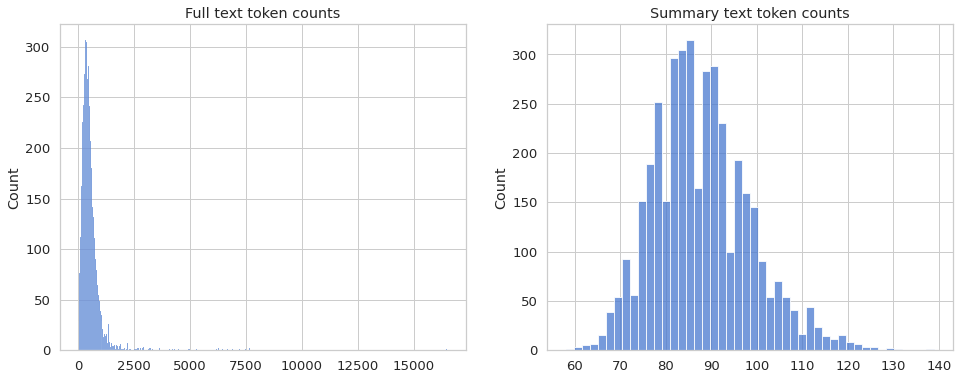

In [28]:
fig, (ax1,ax2) = plt.subplots(1,2)

sns.histplot(text_token_counts,ax=ax1)
ax1.set_title("Full text token counts")

sns.histplot(summary_token_counts,ax=ax2)
ax2.set_title("Summary text token counts")


# **Data Module using DataLoader and Preprocess for training**

In [29]:
N_EPOCHS = 10
BATCH_SIZE = 16

data_module = NewsSummaryDataModule(train_df,test_df,tokenizer,batch_size=BATCH_SIZE)

# **Model Architecture**

In [30]:
class NewsSummaryModel(pl.LightningModule):
    
    def __init__(self):
        super().__init__()
        self.model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME,return_dict=True)
    
    def forward(self,input_ids,attention_mask,decoder_attention_mask, labels=None):
        
        output = self.model(
            input_ids,
            attention_mask = attention_mask,
            labels = labels,
            decoder_attention_mask = decoder_attention_mask
        )
        
        return output.loss, output.logits
    
    def training_step(self, batch, batch_idx):
        
        input_ids = batch["text_input_ids"]
        attention_mask = batch["text_attention_mask"]
        labels = batch["labels"]
        labels_attention_mask = batch["labels_attention_mask"]
        
        loss, outputs = self(
            input_ids = input_ids,
            attention_mask = attention_mask,
            decoder_attention_mask = labels_attention_mask,
            labels = labels
        )
        
        self.log("train_loss",loss,prog_bar=True,logger=True)
        
        return loss
    
    
    def validation_step(self, batch, batch_idx):
        
        input_ids = batch["text_input_ids"]
        attention_mask = batch["text_attention_mask"]
        labels = batch["labels"]
        labels_attention_mask = batch["labels_attention_mask"]
        
        loss, outputs = self(
            input_ids = input_ids,
            attention_mask = attention_mask,
            decoder_attention_mask = labels_attention_mask,
            labels = labels
        )
        
        self.log("val_loss",loss,prog_bar=True,logger=True)
        
        return loss
    
    def test_step(self, batch, batch_idx):
        
        input_ids = batch["text_input_ids"]
        attention_mask = batch["text_attention_mask"]
        labels = batch["labels"]
        labels_attention_mask = batch["labels_attention_mask"]
        
        loss, outputs = self(
            input_ids = input_ids,
            attention_mask = attention_mask,
            decoder_attention_mask = labels_attention_mask,
            labels = labels
        )
        
        self.log("test_loss",loss,prog_bar=True,logger=True)
        
        return loss
    
    
    def configure_optimizers(self):
        return AdamW(self.parameters(),lr = 0.0001)

In [31]:
model = NewsSummaryModel()

Downloading:   0%|          | 0.00/892M [00:00<?, ?B/s]

In [32]:
##%load_ext tensorboard
##%tensorboard --logdir ./lightning_logs

In [33]:
import torch
torch.cuda.is_available()

True

In [34]:
checkpoint_callback = ModelCheckpoint(
    dirpath="checkpoints",
    filename="best-checkpoint",
    save_top_k=1,
    verbose=True,
    monitor="val_loss",
    mode="min"
)

logger = TensorBoardLogger("lightning_loss",name="news-summary")


trainer = pl.Trainer(
    logger=logger,
    callbacks=[checkpoint_callback],
    max_epochs=N_EPOCHS,
    gpus=1,
    enable_progress_bar=True
)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:448: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


# **Training**

In [35]:
trainer.fit(model,datamodule = data_module)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                       | Params
-----------------------------------------------------
0 | model | T5ForConditionalGeneration | 222 M 
-----------------------------------------------------
222 M     Trainable params
0         Non-trainable params
222 M     Total params
891.614   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1896: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 1: 'val_loss' reached 1.19765 (best 1.19765), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 2: 'val_loss' reached 1.17948 (best 1.17948), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 3: 'val_loss' reached 1.17448 (best 1.17448), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 4: 'val_loss' reached 1.17033 (best 1.17033), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 5: 'val_loss' reached 1.16653 (best 1.16653), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 6: 'val_loss' reached 1.16199 (best 1.16199), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 6, global step 7: 'val_loss' reached 1.15788 (best 1.15788), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 7, global step 8: 'val_loss' reached 1.15409 (best 1.15409), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 8, global step 9: 'val_loss' reached 1.15106 (best 1.15106), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 9, global step 10: 'val_loss' reached 1.14798 (best 1.14798), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


# **Using the Model for Inference**

In [36]:
trained_model = NewsSummaryModel.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

trained_model.freeze()

# **Function to Predict Summary**

In [37]:
def summarize_text(text):
    text_encoding = tokenizer(
        text,
        max_length = 512,
        padding = "max_length",
        truncation = True,
        return_attention_mask = True,
        add_special_tokens = True,
        return_tensors = "pt"
    )
    
    generated_ids = trained_model.model.generate(
        input_ids = text_encoding["input_ids"],
        attention_mask = text_encoding["attention_mask"],
        max_length=150,
        num_beams=2,
        repetition_penalty=2.5,
        length_penalty=1.0,
        early_stopping=True
    )
    
    preds = [tokenizer.decode(gen_id,skip_special_tokens=True,clean_up_tokenization_spaces=True)
             for gen_id in generated_ids]
    
    return " ".join(preds)

# **Prediction on Test Data**

In [38]:
sample_row = test_df.iloc[0]
text = sample_row["text"]
model_summary = summarize_text(text)

In [39]:
text

'Washington, Mar 27 (PTI) A 38-year-old woman in the US, who was apprehended twice for allegedly trying to jump the White House fence last week, has been arrested for scaling a fence at the Treasury Building. Marci Anderson Wahl of Everett, Washington, was arrested after an alarm sounded at about 2:15 am yesterday when she scaled a fence at the Treasury Building, next to the White House. Police said Wahl has told them she was there to speak to US President Donald Trump, the CNN reported. She was charged with unlawful entry and contempt of court. Wahl was first arrested on March 21 last week for trying to jump the White House fence. Once in custody, it was determined that Wahl had been issued a "stay away" order for the White House complex after the incident. On March 21, officers saw Wahl walking and staring at the White House complex before discovering she had jumped a fence on the south side but got stuck. Officers found her hanging from the inside of the fence by her shoelaces, whic

In [40]:
model_summary

'Marci Anderson Wahl, 38, of Everett, was arrested after an alarm sounded at about 2:15 am yesterday when she scaled a fence at the Treasury Building, next to the White House. police said Wahl has told them she was there to speak to US President Donald Trump, the CNN reported.'

In [41]:
sample_row["summary"]

'A woman, who was arrested twice last week for trying to jump the White House fence, has been arrested for the third time for scaling a fence at the Treasury Building, next to the White House. The woman, who told officers that she wanted to speak to President Donald Trump, has been charged with unlawful entry and contempt of court.'

# **Prediction On Random News**

# *Vedanta's chairman Anil Agarwal earlier this week announced the biggest investment of ₹1.54 lakh crore for setting up the country's first-ever semiconductor chip plant in Gujarat. This led to a strong buying on stock exchanges that drove Vedanta to rise nearly 18% this week. However, on the last trading day of the current week, Vedanta shares pulled back and slipped by at least nearly 9% on BSE after the company said, the semiconductor plant project is not under their ambit but will be undertaken by Volcan Investments.On Thursday, in its regulatory filing, Vedanta said, " we reiterate that the proposed business of manufacturing semiconductors is not under Vedanta and we understand that it will be undertaken by the ultimate holding company of Vedanta, Volcan Investments."This week, in a statement, Vedanta said the company signed two Memorandum of Understanding (MoUs) with the Gujarat government to set up a semiconductor fab unit, a display fab unit, and a semiconductor assembling and testing unit in the Ahmedabad district of the state.*

In [46]:
text = "Vedanta's chairman Anil Agarwal earlier this week announced the biggest investment of ₹1.54 lakh crore for setting up the country's first-ever semiconductor chip plant in Gujarat. This led to a strong buying on stock exchanges that drove Vedanta to rise nearly 18% this week. However, on the last trading day of the current week, Vedanta shares pulled back and slipped by at least nearly 9% on BSE after the company said, the semiconductor plant project is not under their ambit but will be undertaken by Volcan Investments.On Thursday, in its regulatory filing, Vedanta said, we reiterate that the proposed business of manufacturing semiconductors is not under Vedanta and we understand that it will be undertaken by the ultimate holding company of Vedanta, Volcan Investments.This week, in a statement, Vedanta said the company signed two Memorandum of Understanding (MoUs) with the Gujarat government to set up a semiconductor fab unit, a display fab unit, and a semiconductor assembling and testing unit in the Ahmedabad district of the state."

In [47]:
summarize_text(text)

"Vedanta's chairman Anil Agarwal earlier this week announced the biggest investment of 1.54 lakh crore for setting up the country's first-ever semiconductor chip plant in Gujarat. This led to a strong buying on stock exchanges that drove Vedanta to rise nearly 18% this week. However, on the last trading day of the current week, Vedanta shares pulled back and slipped by at least nearly 9% on BSE."